# Desafio técnico | Cientista de Dados - Maxpar

Este notebook tem como objetivo realizar uma análise da base de dados de Síndrome Respiratória Aguda Grave (SRAG) do ano de 2023, fornecida pelo OpenData SUS.

Através do tratamento de dados, análise exploratória e aplicação de modelos de machine learning, busca gerar insights relevantes que possam auxiliar na tomada de decisões em saúde pública.

Ele faz parte de uma etapa do processo seletivo do Grupo Autoglass para a vaga **Cientista de Dados - IA Generativa - Vila Velha/ES | Maxpar**

A análise foi dividida em quatro etapas principais, seguindo as orientações contidas no arquivo anexado ao e-mail do desafio:
1. **Tratamento dos dados**: identificação e correção de problemas na base.
2. **Análise descritiva inicial**: estudo de tendências temporais, distribuição geográfica e fatores de risco.
3. **Modelos de Machine Learning**: criação de modelos para prever a evolução dos casos (óbito ou não).
4. **Conclusões e recomendações**: geração de insights para apoiar políticas públicas de saúde.

## 0. IMPORTS

Importação das bibliotecas que foram utilizadas no decorrer desta análise de dados

In [158]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split


from IPython.display import Markdown, display

warnings.filterwarnings('ignore')

### 0.1. CARREGAMENTO DA BASE DE DADOS

In [159]:
df = pd.read_csv('INFLUD23-05-05-2025.csv', sep=';', encoding='latin1', low_memory=False) # Carregamento do arquivo .csv com a utilização da biblioteca Pandas
df.head() # Visualização das cinco primeiras linhas do DataFrame

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,VG_ENC,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG
0,21/01/2023,3,20/01/2023,3,MG,DIAMANTINA,1450.0,ARACUAI,310340,HOSPITAL SAO VICENTE DE PAULO ARACUAI,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14/02/2023,7,13/02/2023,7,SC,FLORIANOPOLIS,1476.0,FLORIANOPOLIS,420540,INSTITUTO DE ENSINO E PESQUISA DR IRINEU MAY B...,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/02/2023,7,04/02/2023,5,SP,GVE XXIV RIBEIRAO PRETO,1348.0,CAJURU,350940,CASA DE CARIDADE SAO VICENTE DE PAULO CAJURU,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24/02/2023,8,16/02/2023,7,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,BP MIRANTE,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27/02/2023,9,25/02/2023,8,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690,HOSPITAL UNIVERSITARIO EVANGELICO MACKENZIE,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. DESCRIÇÃO E TRATAMENTO DOS DADOS

In [160]:
df1 = df.copy() # A cada mudança de tópico o DataFrame anterior é copiado e atribuído a uma nova variável. Faço isso para caso seja necessário rodar os dados de novo, não ser preciso rodar todo o notebook, apenas a seção que estou trabalhando
df1.head()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,VG_ENC,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG
0,21/01/2023,3,20/01/2023,3,MG,DIAMANTINA,1450.0,ARACUAI,310340,HOSPITAL SAO VICENTE DE PAULO ARACUAI,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14/02/2023,7,13/02/2023,7,SC,FLORIANOPOLIS,1476.0,FLORIANOPOLIS,420540,INSTITUTO DE ENSINO E PESQUISA DR IRINEU MAY B...,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/02/2023,7,04/02/2023,5,SP,GVE XXIV RIBEIRAO PRETO,1348.0,CAJURU,350940,CASA DE CARIDADE SAO VICENTE DE PAULO CAJURU,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24/02/2023,8,16/02/2023,7,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030,BP MIRANTE,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27/02/2023,9,25/02/2023,8,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690,HOSPITAL UNIVERSITARIO EVANGELICO MACKENZIE,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1. DIMENSÃO DOS DADOS

Verificação da quantidade de linhas e colunas da base original

In [161]:
print(f'Quantidade de linhas: {df1.shape[0]}')
print(f'Quantidade de colunas: {df1.shape[1]}')

print(f'\nColunas disponíveis: {df.columns.tolist()}')

Quantidade de linhas: 278980
Quantidade de colunas: 190

Colunas disponíveis: ['DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT', 'ID_REGIONA', 'CO_REGIONA', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_UNIDADE', 'CO_UNI_NOT', 'CS_SEXO', 'DT_NASC', 'NU_IDADE_N', 'TP_IDADE', 'COD_IDADE', 'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'ID_PAIS', 'CO_PAIS', 'SG_UF', 'ID_RG_RESI', 'CO_RG_RESI', 'ID_MN_RESI', 'CO_MUN_RES', 'CS_ZONA', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC', 'VACINA', 'DT_UT_DOSE', 'MAE_VAC', 'DT_VAC_MAE', 'M_AMAMENTA', 'DT_DOSEUNI', 'DT_1_DOSE', 'DT_2_DOSE', 'ANTIVIRAL', 'TP_ANTIVIR', 'OUT_ANTIV', 'DT_ANTIVIR', 'HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_IN

### 1.2. TIPOS DE DADOS

Obtenção dos tipos de dados, conversão de colunas para os tipos apropriados (ex: datas e numéricos) e geração de estatísticas descritivas (média, mediana, desvio-padrão etc)

In [162]:
df1.dtypes

DT_NOTIFIC     object
SEM_NOT         int64
DT_SIN_PRI     object
SEM_PRI         int64
SG_UF_NOT      object
               ...   
FAB_RE_BI      object
DOSE_ADIC      object
DOS_RE_BI      object
LOTE_ADIC      object
TABAG         float64
Length: 190, dtype: object

#### 1.2.1. TRANSFORMAÇÃO DOS TIPOS DE DADOS

In [163]:
# Todas as colunas com DT são referentes a uma data, mas estão classificadas como uma string (object), realizei a alteração de todas as colunas para o formato datetime

colunas_data = [col for col in df1.columns if col.startswith('DT_')] # Loop for buscando todas as colunas que começam com 'DT_'
df1[colunas_data] = df1[colunas_data].apply(pd.to_datetime, errors = 'coerce') # Função que converte string (object) em datetime64[ns]
df1[colunas_data].dtypes # Confirmar que todas as colunas foram devidamente alteradas
df1['EVOLUCAO'] = pd.to_numeric(df1['EVOLUCAO'], errors='coerce').astype('Int64') # No item 1.6 tive um problema por conta do tipo de dado, como existia uma seção para isso, coloquei aqui para ficar mais organizado

#### 1.2.2. DESCRIÇÃO ESTATÍSTICA DOS DADOS

In [164]:
df1.describe().T # Utilização do método .describe() para resumo das descrições estatísticas do DataFrame

,count,mean,std,min,25%,50%,75%,max
SEM_NOT,278980.0,24.611055,13.878645,1.0,13.0,23.0,36.0,52.0
SEM_PRI,278980.0,24.167991,13.925095,1.0,13.0,22.0,36.0,52.0
CO_REGIONA,243685.0,1560.322888,652.749729,1331.0,1348.0,1418.0,1519.0,6256.0
CO_MUN_NOT,278980.0,346439.014954,92149.88152,110002.0,310620.0,352530.0,410830.0,530010.0
CO_UNI_NOT,278980.0,3187047.254792,2388095.595014,35.0,2081490.0,2493853.0,3356868.0,9997091.0
...,...,...,...,...,...,...,...,...
VG_MET,1752.0,2.308219,1.124861,1.0,1.0,3.0,3.0,4.0
VG_ENC,1613.0,2.594544,1.619291,1.0,1.0,3.0,4.0,5.0
VG_REINF,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REINF,270338.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0


### 1.3. SELEÇÃO DE COLUNAS

A base foi carregada a partir do arquivo `INFLUD-21-05-2024.csv`, contendo 278.980 registros e 190 variáveis. Devido à complexidade e volume da base, foram selecionadas apenas as colunas consideradas relevantes para o objetivo da análise.

In [165]:
colunas_selecionadas = ['DT_NOTIFIC', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'CS_RACA', 'CS_ESCOL_N', 
                        'FEBRE', 'TOSSE', 'VACINA', 'UTI', 'SUPORT_VEN', 'EVOLUCAO', 'CLASSI_FIN',
                        'CARDIOPATI', 'DIABETES', 'OBESIDADE', 'PUERPERA'] # Lista com as colunas selecionadas

df_selecionado = df1[colunas_selecionadas].copy() # Criação de um novo DataFrame apenas com as colunas selecionadas
df_selecionado.head()

,DT_NOTIFIC,SG_UF_NOT,CS_SEXO,NU_IDADE_N,CS_RACA,CS_ESCOL_N,FEBRE,TOSSE,VACINA,UTI,SUPORT_VEN,EVOLUCAO,CLASSI_FIN,CARDIOPATI,DIABETES,OBESIDADE,PUERPERA
0,2023-01-21,MG,F,82,1.0,1,1.0,1.0,1.0,2.0,NaN,1,5.0,2.0,1.0,2.0,2.0
1,2023-02-14,SC,M,76,1.0,NaN,NaN,NaN,NaN,2.0,3.0,1,4.0,1.0,NaN,NaN,NaN
2,2023-02-16,SP,F,18,1.0,NaN,1.0,1.0,NaN,NaN,3.0,1,5.0,NaN,NaN,NaN,NaN
3,2023-02-24,SP,F,20,4.0,9,NaN,NaN,9.0,NaN,NaN,1,5.0,NaN,NaN,NaN,NaN
4,2023-02-27,PR,M,2,4.0,5,1.0,1.0,9.0,2.0,3.0,1,2.0,NaN,NaN,NaN,NaN


### 1.4. CHECAGEM DE VALORES NULOS

Identificação de colunas com dados ausentes

In [166]:
df_selecionado.isna().sum()

DT_NOTIFIC         0
SG_UF_NOT          0
CS_SEXO            0
NU_IDADE_N         0
CS_RACA            1
CS_ESCOL_N     99971
FEBRE          39126
TOSSE          25030
VACINA        125978
UTI            32851
SUPORT_VEN     34666
EVOLUCAO       13759
CLASSI_FIN      8184
CARDIOPATI    183545
DIABETES      189043
OBESIDADE     198039
PUERPERA      198799
dtype: int64

### 1.5. FILTRAGEM E SUBSTITUIÇÃO DE VALORES NULOS

Linhas com valores nulos foram substituídas por "Ignorado" e, quando necessário, ocorreu a filtragem com a exclusão de linhas com essa informação

In [167]:
colunas_ignorar_nulo = ['CS_RACA', 'CS_ESCOL_N', 'FEBRE', 'TOSSE', 'VACINA', 'UTI', 'SUPORT_VEN', 
                        'CLASSI_FIN', 'CARDIOPATI', 'DIABETES', 'OBESIDADE', 'PUERPERA'] # Seleção das colunas que serão tratadas

for col in colunas_ignorar_nulo:
    df_selecionado[col] = df_selecionado[col].fillna('Ignorado') # Loop for que atribui 'Igonorado' em todos os valores nulos dentro das colunas selecionadas

df_selecionado = df_selecionado[df_selecionado['EVOLUCAO'] != 'Ignorado'] # Filtragem do dataset excluindo as linhas onde a coluna EVOLUCAO possui valor 'Ignorado'

df_selecionado.isna().sum() # Verifica se todos os valores nulos foram tratados

DT_NOTIFIC    0
SG_UF_NOT     0
CS_SEXO       0
NU_IDADE_N    0
CS_RACA       0
CS_ESCOL_N    0
FEBRE         0
TOSSE         0
VACINA        0
UTI           0
SUPORT_VEN    0
EVOLUCAO      0
CLASSI_FIN    0
CARDIOPATI    0
DIABETES      0
OBESIDADE     0
PUERPERA      0
dtype: int64

### 1.6. MAPEAMENTO EM VARIÁVEIS CATEGÓRICAS

Como as variáveis categóricas na base de dados estavam representadas por códigos numéricos (por exemplo, de 1 a 9), a leitura e a apresentação dessas informações em gráficos ficariam comprometidas. Por isso, os códigos foram substituídos por rótulos com palavras mais representativas e compreensíveis.

Posteriormente, será necessário aplicar técnicas de conversão dessas variáveis categóricas em numéricas, para que os modelos de Machine Learning possam utilizá-las adequadamente. No entanto, essa etapa não faz parte da análise atual.

In [168]:
map_binario = {1: 'Sim', 2: 'Não', 3.0: 'Ignorado', 9: 'Ignorado'}
map_sexo = {'M': 'Masculino', 'F': 'Feminino'}
map_evolucao = {1: 'Cura', 2: 'Óbito', 3: 'Óbito por outras causas', 9: 'Ignorado'}
map_classi = {1: 'SRAG por Influenza', 2: 'SRAG por outro vírus', 3: 'SRAG por outro agente etiológico',
              4: 'SRAG não especificado', 5: 'SRAG por COVID-19'}

In [169]:
df_selecionado['CS_SEXO'] = df_selecionado['CS_SEXO'].map(map_sexo) # Substituição pelos valores do dicionário map_sexo
df_selecionado['EVOLUCAO'] = df_selecionado['EVOLUCAO'].map(map_evolucao) # Substituição pelos valores do dicionário map_evolucao
df_selecionado['CLASSI_FIN'] = df_selecionado['CLASSI_FIN'].map(map_classi) # Substituição pelos valores do dicionário map_classi

for col in ['FEBRE', 'TOSSE', 'VACINA', 'UTI', 'SUPORT_VEN', 'CARDIOPATI', 'DIABETES', 'OBESIDADE', 'PUERPERA']:
    df_selecionado[col] = df_selecionado[col].replace(map_binario) # Substituição pelos valores do dicionário map_binario

In [170]:
for col in ['FEBRE', 'TOSSE', 'VACINA', 'UTI', 'SUPORT_VEN', 'CARDIOPATI', 'DIABETES', 'OBESIDADE', 'PUERPERA']:
    print(f"{col}: {df_selecionado[col].unique()}") # O método .map() não apresentou o resultado esperado nas colunas selecionados, por esse motivo foi utilizado o método .replace() e aqui foi verificado se os valores foram substituídos de forma correta

FEBRE: ['Sim' 'Ignorado' 'Não']
TOSSE: ['Sim' 'Ignorado' 'Não']
VACINA: ['Sim' 'Ignorado' 'Não']
UTI: ['Não' 'Ignorado' 'Sim']
SUPORT_VEN: ['Ignorado' 'Não' 'Sim']
CARDIOPATI: ['Não' 'Sim' 'Ignorado']
DIABETES: ['Sim' 'Ignorado' 'Não']
OBESIDADE: ['Não' 'Ignorado' 'Sim']
PUERPERA: ['Não' 'Ignorado' 'Sim']


In [171]:
df_selecionado.head() # Visão geral do DataFrame reduzido após os tratamentos realizados

,DT_NOTIFIC,SG_UF_NOT,CS_SEXO,NU_IDADE_N,CS_RACA,CS_ESCOL_N,FEBRE,TOSSE,VACINA,UTI,SUPORT_VEN,EVOLUCAO,CLASSI_FIN,CARDIOPATI,DIABETES,OBESIDADE,PUERPERA
0,2023-01-21,MG,Feminino,82,1.0,1,Sim,Sim,Sim,Não,Ignorado,Cura,SRAG por COVID-19,Não,Sim,Não,Não
1,2023-02-14,SC,Masculino,76,1.0,Ignorado,Ignorado,Ignorado,Ignorado,Não,Ignorado,Cura,SRAG não especificado,Sim,Ignorado,Ignorado,Ignorado
2,2023-02-16,SP,Feminino,18,1.0,Ignorado,Sim,Sim,Ignorado,Ignorado,Ignorado,Cura,SRAG por COVID-19,Ignorado,Ignorado,Ignorado,Ignorado
3,2023-02-24,SP,Feminino,20,4.0,9,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Cura,SRAG por COVID-19,Ignorado,Ignorado,Ignorado,Ignorado
4,2023-02-27,PR,Masculino,2,4.0,5,Sim,Sim,Ignorado,Não,Ignorado,Cura,SRAG por outro vírus,Ignorado,Ignorado,Ignorado,Ignorado


### 1.7. TRATAMENTO DE OUTLIERS OU VALORES INCONSISTENTES

A única variável numérica restante após os tratamentos foi a idade. Foi inserido um boxplot com o objetivo de verificar visualmente a presença de outliers no dataset.

No entanto, foi observada a presença de valores negativos na variável NU_IDADE_N, o que é logicamente impossível. Por esse motivo, registros com valores inferiores a zero foram removidos.

O valor máximo encontrado para a idade foi 123. Embora seja incomum, trata-se de um valor plausível e, portanto, foi mantido na base.

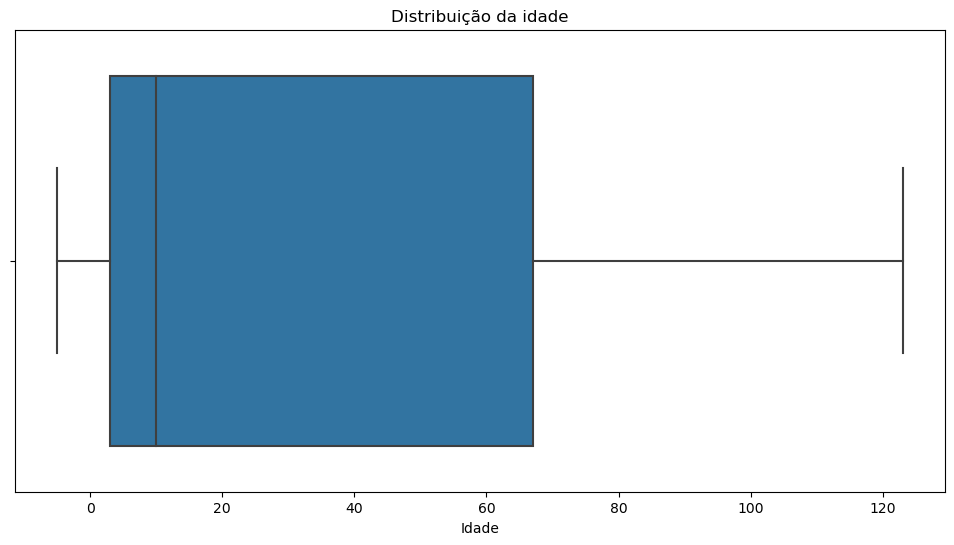

In [172]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_selecionado['NU_IDADE_N'])
plt.title("Distribuição da idade")
plt.xlabel("Idade")
plt.show();

In [173]:
df_selecionado['NU_IDADE_N'].sort_values(ascending=True) # É possível observar que duas linhas possuem valores de idade inferiores a zero. Trata-se, provavelmente, de um erro de digitação, sendo possível que a idade correta corresponda ao módulo desse valor. No entanto, por segurança, esses registros serão removidos da base
df_selecionado = df_selecionado[df_selecionado['NU_IDADE_N'] >= 0]
df_selecionado['NU_IDADE_N'].sort_values(ascending=True) # Foi constatado que as linhas com valores negativos foram devidamente removidas do dataset

137375      0
105881      0
85661       0
199455      0
184895      0
         ... 
84584     113
210955    114
234710    117
203274    121
271737    123
Name: NU_IDADE_N, Length: 265219, dtype: int64

## 2. ANÁLISE DESCRITIVA INICIAL

### 2.1. DISTRIBUIÇÃO DE CASOS POR EVOLUÇÃO

In [174]:
df2 = df_selecionado.copy()

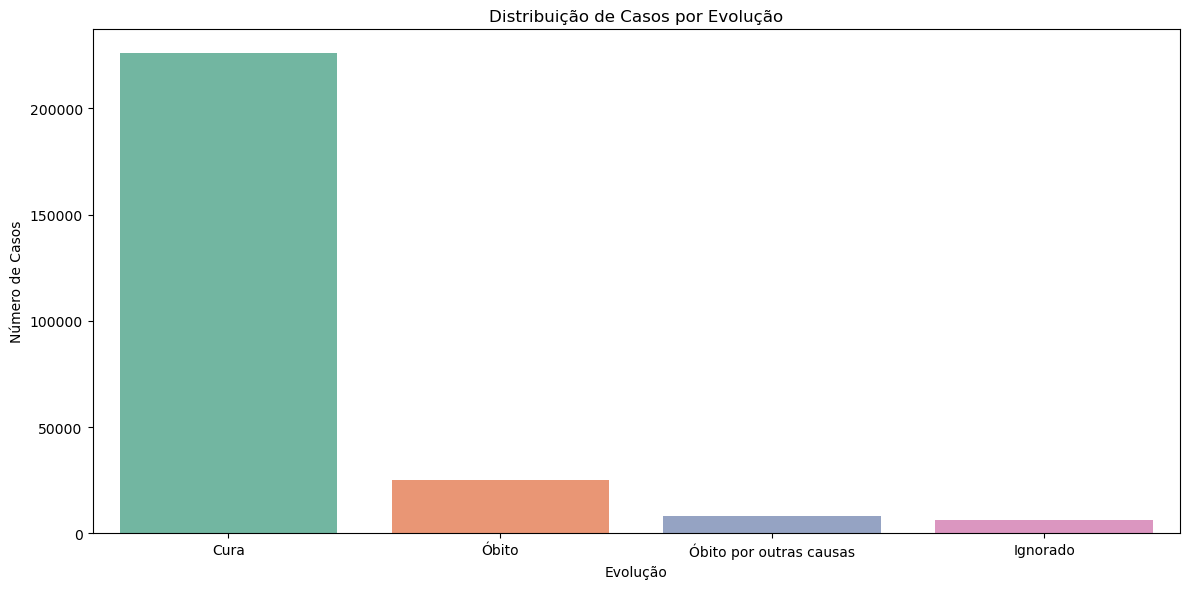

É possível observar que a quantidade de pacientes curados é significativamente maior do que os demais casos de evolução.

O que já nos mostra que a nossa variável alvo, óbito e não óbito (aqui atribuída como 'Cura'), está desbalanceada.

In [197]:
evolucao_counts = df2['EVOLUCAO'].value_counts() # Contador dos quatro possíveis casos de evolução

plt.figure(figsize=(12, 6))
sns.barplot(x=evolucao_counts.index, y=evolucao_counts.values, palette='Set2')
plt.title('Distribuição de Casos por Evolução')
plt.ylabel('Número de Casos')
plt.xlabel('Evolução')
plt.tight_layout()
plt.show()

display(Markdown("É possível observar que a quantidade de pacientes curados é significativamente maior do que os demais casos de evolução.\n\nO que já nos mostra que a nossa variável alvo, óbito e não óbito (aqui atribuída como 'Cura'), está desbalanceada."))

### 2.2. ÓBITOS POR FAIXA ETÁRIA

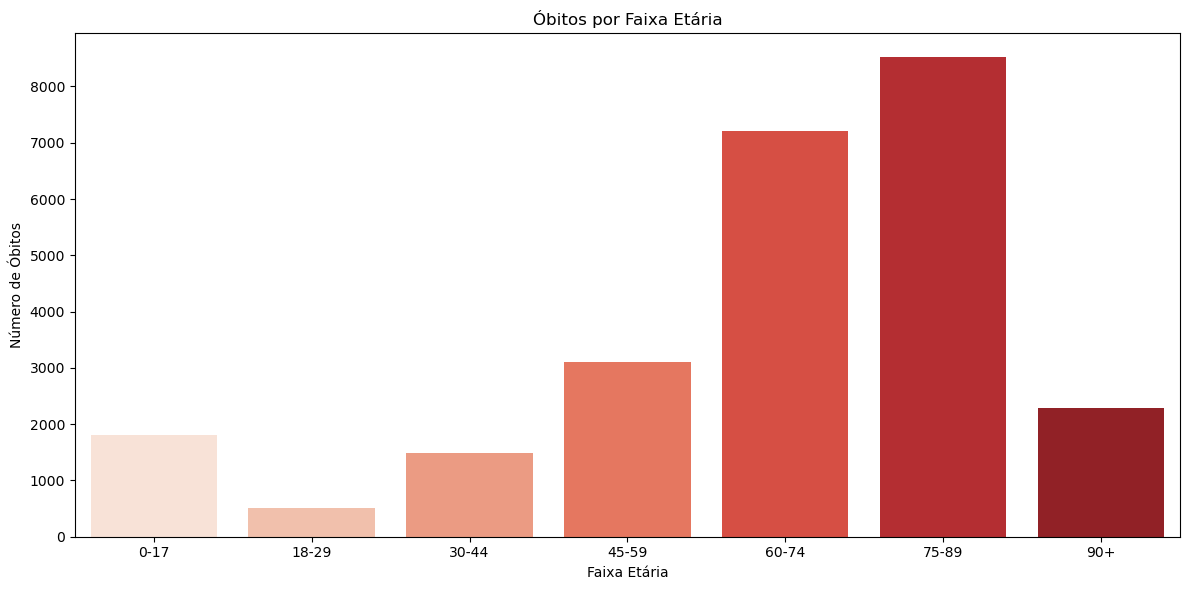

Constação de algo que já era esperado: Quanto maior a idade, maiores são as chances de falecer por SRAG.

É importante destacar que a redução nos casos na faixa etária de 90 anos ou mais não indica maior resistência à SRAG, mas sim reflete o fato de que poucas pessoas conseguem atingir idades tão avançadas.

In [176]:
bins = [0, 18, 30, 45, 60, 75, 90, 120]
labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']
df2['FAIXA_ETARIA'] = pd.cut(df2['NU_IDADE_N'], bins=bins, labels=labels)

faixa_obitos = df2[df2['EVOLUCAO'] == 'Óbito']['FAIXA_ETARIA'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=faixa_obitos.index, y=faixa_obitos.values, palette='Reds')
plt.title('Óbitos por Faixa Etária')
plt.ylabel('Número de Óbitos')
plt.xlabel('Faixa Etária')
plt.tight_layout()
plt.show()

display(Markdown("Constação de algo que já era esperado: Quanto maior a idade, maiores são as chances de falecer por SRAG.\n\nÉ importante destacar que a redução nos casos na faixa etária de 90 anos ou mais não indica maior resistência à SRAG, mas sim reflete o fato de que poucas pessoas conseguem atingir idades tão avançadas."))

### 2.3. COMPARATIVO ENTRE VACINADOS E NÃO VACINADOS

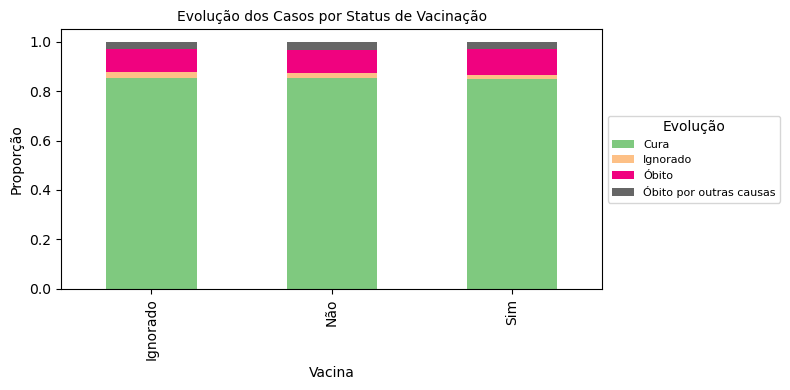

Em um primeiro momento, o resulto esperado seria outro, visto a importância da vacinação contra SRAG.

Porém é importante destacar que 125.978 linhas foram preenchidas com 'Ignorado'. O que representa aproximadamente 45% do dataset.

Tal fato pode ter influenciado nos resultados apresentados no gráficos 'Sim' e 'Não'.

In [177]:
vacina_evolucao = df2.groupby(['VACINA', 'EVOLUCAO']).size().unstack().fillna(0)

vacina_evolucao_pct = vacina_evolucao.div(vacina_evolucao.sum(axis=1), axis=0)

vacina_evolucao_pct.plot(kind='bar', stacked=True, colormap='Accent', figsize=(8, 4))
plt.title('Evolução dos Casos por Status de Vacinação', fontsize=10)
plt.ylabel('Proporção')
plt.xlabel('Vacina')
plt.legend(title='Evolução', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()



display(Markdown("Em um primeiro momento, o resulto esperado seria outro, visto a importância da vacinação contra SRAG.\n\nPorém é importante destacar que 125.978 linhas foram preenchidas com 'Ignorado'. O que representa aproximadamente 45% do dataset.\n\nTal fato pode ter influenciado nos resultados apresentados no gráficos 'Sim' e 'Não'."))

#### 2.3.1. COMPARATIVO DE ÓBITO ENTRE VACINADOS E NÃO VACINADOS

Como o gráfico do item 2.3 não se mostrou satisfatório para interpretação, é ideal que a análise seja feita observando os óbitos para vacinaos e não vacinados. Dessa forma teremos um parâmetro melhor de comparação.

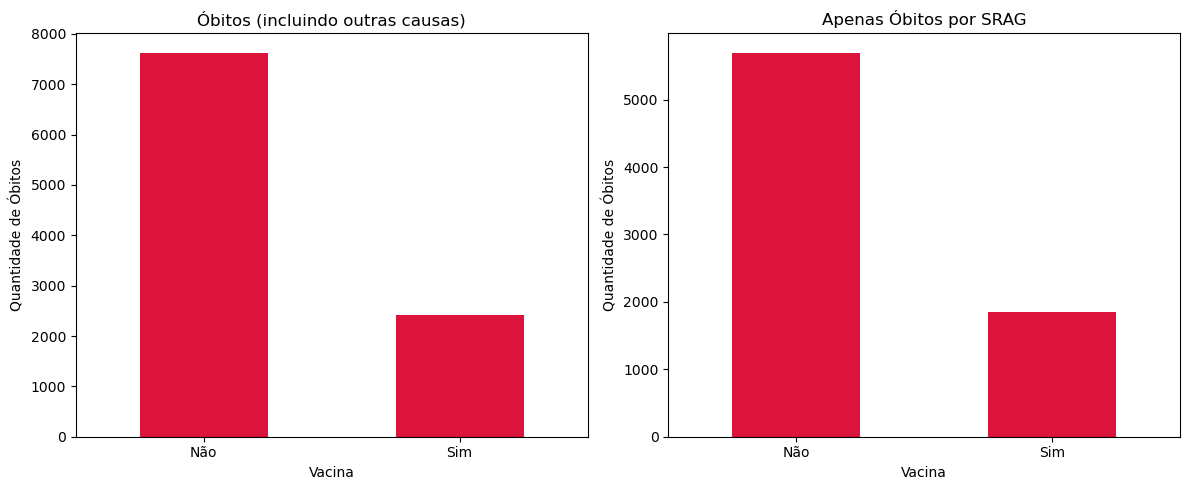

Considerando apenas os casos em que foi possível identificar se a vacina foi ou não aplicada, ou seja, excluindo os registros com o valor 'Ignorado', observa-se que o número de óbitos entre pessoas não vacinadas é superior ao número entre vacinados.

Em relação aos óbitos por SRAG, a proporção de mortes entre os não vacinados é aproximadamente 2 vezes maior do que entre os vacinados. Enquanto para óbitos incluindo outras causas é de aproximadamente 2.5 vezes.

In [178]:
obitos = df2[(df2['EVOLUCAO'].isin(['Óbito', 'Óbito por outras causas'])) &(df2['VACINA'] != 'Ignorado')] # Filtrando apenas para evoluções que terminaram em óbito, incluindo óbitos por outras causas
obitos_2 = df2[(df2['EVOLUCAO'] == 'Óbito') & (df2['VACINA'] != 'Ignorado')] # Excluindo óbitos por outras causas

obitos_por_vacina = obitos['VACINA'].value_counts().sort_index() # Conta quantos óbitos houve para cada status de vacinação
obitos_por_vacina_2 = obitos_2['VACINA'].value_counts().sort_index() # Excluindo óbitos por outras causas

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Criando a figura com 2 subplots lado a lado

obitos_por_vacina.plot(kind='bar', color='crimson', ax=axes[0])
axes[0].set_title('Óbitos (incluindo outras causas)')
axes[0].set_xlabel('Vacina')
axes[0].set_ylabel('Quantidade de Óbitos')
axes[0].tick_params(axis='x', rotation=0)

# Gráfico 2: só óbitos principais
obitos_por_vacina_2.plot(kind='bar', color='crimson', ax=axes[1])
axes[1].set_title('Apenas Óbitos por SRAG')
axes[1].set_xlabel('Vacina')
axes[1].set_ylabel('Quantidade de Óbitos')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

display(Markdown("Considerando apenas os casos em que foi possível identificar se a vacina foi ou não aplicada, ou seja, excluindo os registros com o valor 'Ignorado', observa-se que o número de óbitos entre pessoas não vacinadas é superior ao número entre vacinados.\n\nEm relação aos óbitos por SRAG, a proporção de mortes entre os não vacinados é aproximadamente 2 vezes maior do que entre os vacinados. Enquanto para óbitos incluindo outras causas é de aproximadamente 2.5 vezes."))

### 2.4. ÓBITOS POR CORMOMIDADE

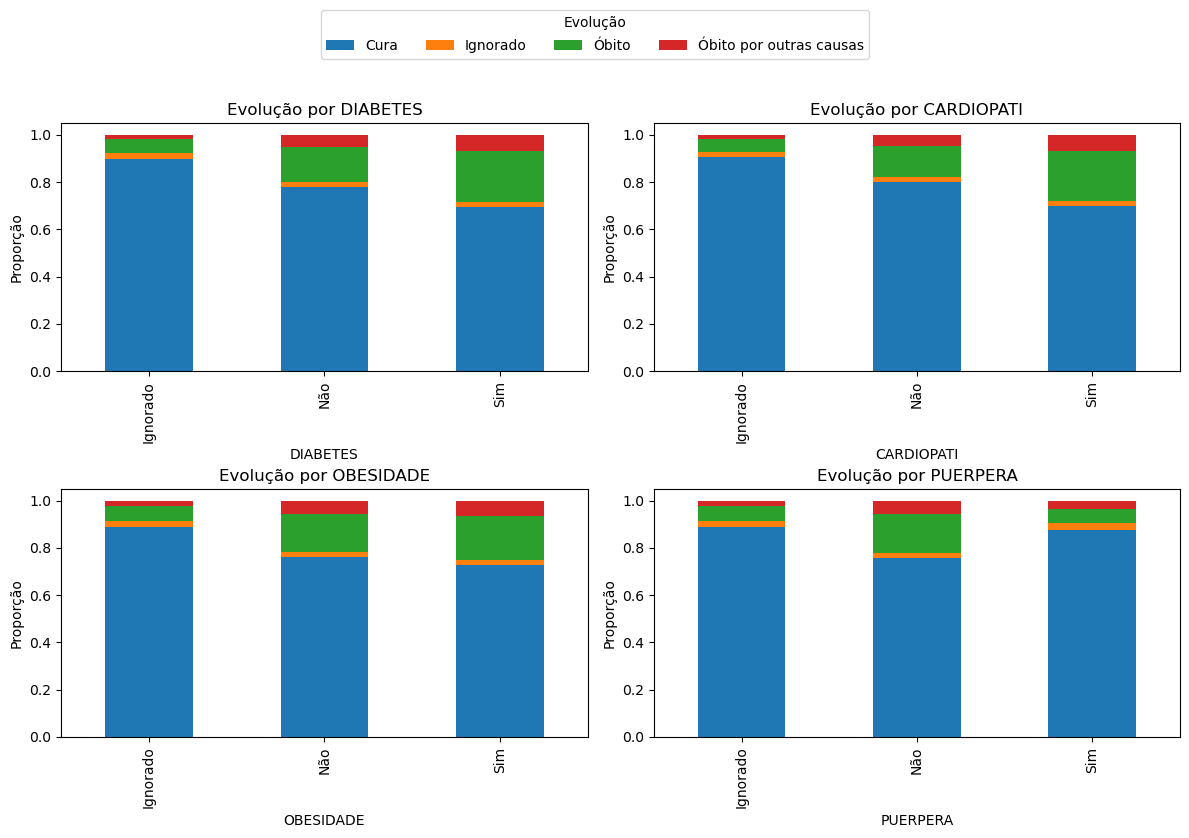

Como foi amplamente divulgado na imprensa, pessoas pertencentes a grupos de risco têm maior probabilidade de óbito em decorrência da SRAG.

É possível observar que, com exceção de mulheres em puerpério, em todos os outros casos é constatado que pessoas com comorbidade tem uma proporção maior de óbito que pessoas sem comormidade.

In [179]:
comorbidades = ['DIABETES', 'CARDIOPATI', 'OBESIDADE', 'PUERPERA']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, comorb in enumerate(comorbidades):
    dados = df2.groupby([comorb, 'EVOLUCAO']).size().unstack().fillna(0)
    dados_pct = dados.div(dados.sum(axis=1), axis=0)

    dados_pct.plot(
        kind='bar',
        stacked=True,
        ax=axs[i],
        title=f'Evolução por {comorb}',
        legend=False
    )
    axs[i].set_ylabel('Proporção')
    axs[i].set_xlabel(comorb)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Evolução', loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

display(Markdown("Como foi amplamente divulgado na imprensa, pessoas pertencentes a grupos de risco têm maior probabilidade de óbito em decorrência da SRAG.\n\nÉ possível observar que, com exceção de mulheres em puerpério, em todos os outros casos é constatado que pessoas com comorbidade tem uma proporção maior de óbito que pessoas sem comormidade."))

### 2.5. CASOS DE SRAG AO LONGO DO ANO

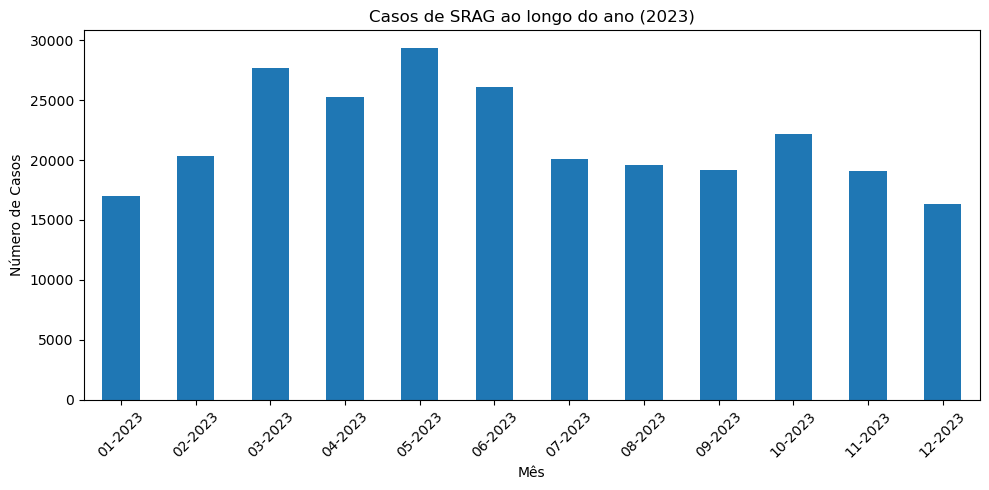

É possível destacar que, ao longo de 2023, os meses com maior número de registros de casos de SRAG foram, respectivamente: maio, fevereiro e junho.

Maio e junho são meses mais frios em grande parte do país. A população começa a enfrentar temperaturas mais baixas, o que pode favorecer o aumento de casos, uma vez que infecções respiratórias tendem a ser mais comuns nesse período.

Em relação a março de 2023, o aumento nos casos de SRAG pode estar associado ao Carnaval, celebrado na última semana de fevereiro. Como as SRAGs são altamente contagiosas, as aglomerações características da festa podem ter contribuído significativamente para a disseminação da doença.

In [180]:
# Filtrar apenas 2023
df_2023 = df2[df2['DT_NOTIFIC'].dt.year == 2023]

# Agrupar por mês
casos_por_mes = df_2023['DT_NOTIFIC'].dt.to_period('M').value_counts().sort_index()

casos_por_mes.index = casos_por_mes.index.strftime('%m-%Y')

plt.figure(figsize=(10, 5))
casos_por_mes.plot(kind='bar')
plt.title('Casos de SRAG ao longo do ano (2023)')
plt.ylabel('Número de Casos')
plt.xlabel('Mês')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(Markdown("É possível destacar que, ao longo de 2023, os meses com maior número de registros de casos de SRAG foram, respectivamente: maio, fevereiro e junho.\n\nMaio e junho são meses mais frios em grande parte do país. A população começa a enfrentar temperaturas mais baixas, o que pode favorecer o aumento de casos, uma vez que infecções respiratórias tendem a ser mais comuns nesse período.\n\nEm relação a março de 2023, o aumento nos casos de SRAG pode estar associado ao Carnaval, celebrado na última semana de fevereiro. Como as SRAGs são altamente contagiosas, as aglomerações características da festa podem ter contribuído significativamente para a disseminação da doença."))

### 2.6. CASOS DE SRAG POR ESTADO (UF) E DISTRITO FEDERAL (DF)

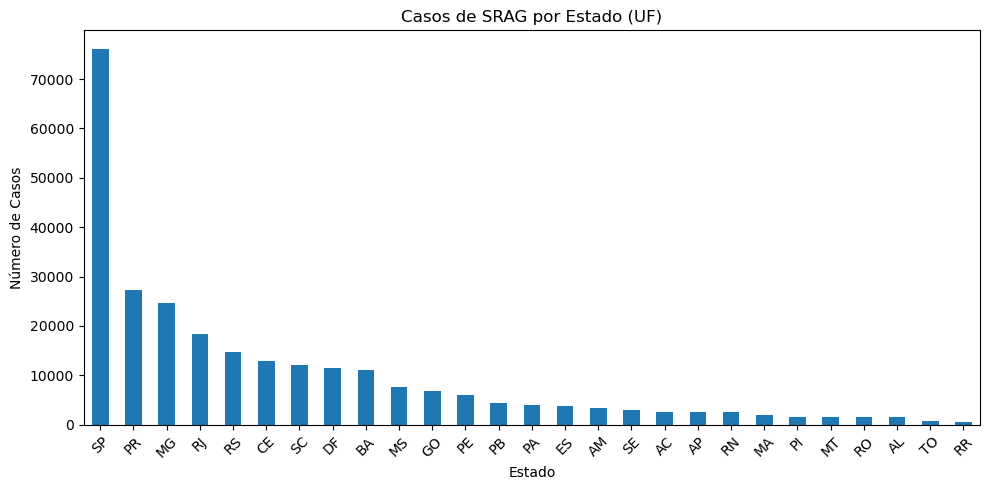

Os estados mais populosos do Brasil são: São Paulo, Minas Gerais e Rio de Janeiro. A presença desses três estados entre os que registraram maior número de casos pode estar associada às suas grandes populações.

O estado do Paraná é o 5º mais populoso do país, seguido pelo Rio Grande do Sul. Além disso, ambos costumam registrar temperaturas mais baixas durante os períodos frios do ano, o que também pode contribuir para o aumento no número de casos.

In [181]:
casos_por_uf = df2['SG_UF_NOT'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
casos_por_uf.plot(kind='bar')
plt.title('Casos de SRAG por Estado (UF)')
plt.ylabel('Número de Casos')
plt.xlabel('Estado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(Markdown("Os estados mais populosos do Brasil são: São Paulo, Minas Gerais e Rio de Janeiro. A presença desses três estados entre os que registraram maior número de casos pode estar associada às suas grandes populações.\n\nO estado do Paraná é o 5º mais populoso do país, seguido pelo Rio Grande do Sul. Além disso, ambos costumam registrar temperaturas mais baixas durante os períodos frios do ano, o que também pode contribuir para o aumento no número de casos."))

## 3. MODELOS DE MACHINE LEARNING

### 3.1. FILTRAGEM DA VARIÁVEL ALVO

In [182]:
df3 = df2[df2['EVOLUCAO'].isin(['Cura', 'Óbito', 'Óbito por outras causas'])] # Exclusão de linhas que tenham como evolução 'Ignorado'
df3['EVOLUCAO'].unique() # Verificar se os únicos valores dentro da coluna 'EVOLUCAO' são 'Cura', 'Óbito', 'Óbito por outras causas'

array(['Cura', 'Óbito', 'Óbito por outras causas'], dtype=object)

### 3.2. CRIAÇÃO E SEPARAÇÃO DO TARGET

In [183]:
df3['OBITO'] = df3['EVOLUCAO'].apply(lambda x: 1 if x == 'Óbito' or x == 'Óbito por outras causas' else 0) # Atribuição de um rótulo para a variável alvo
df3['OBITO'].value_counts() # Trata-se de um dataset desbalanceado, isso será manipulado mais a frete

0    225920
1     33271
Name: OBITO, dtype: int64

In [184]:
df3.head() # Verificar como o dataset ficou após as alterações realizadas e se a última coluna foi preenchida

,DT_NOTIFIC,SG_UF_NOT,CS_SEXO,NU_IDADE_N,CS_RACA,CS_ESCOL_N,FEBRE,TOSSE,VACINA,UTI,SUPORT_VEN,EVOLUCAO,CLASSI_FIN,CARDIOPATI,DIABETES,OBESIDADE,PUERPERA,FAIXA_ETARIA,OBITO
0,2023-01-21,MG,Feminino,82,1.0,1,Sim,Sim,Sim,Não,Ignorado,Cura,SRAG por COVID-19,Não,Sim,Não,Não,75-89,0
1,2023-02-14,SC,Masculino,76,1.0,Ignorado,Ignorado,Ignorado,Ignorado,Não,Ignorado,Cura,SRAG não especificado,Sim,Ignorado,Ignorado,Ignorado,75-89,0
2,2023-02-16,SP,Feminino,18,1.0,Ignorado,Sim,Sim,Ignorado,Ignorado,Ignorado,Cura,SRAG por COVID-19,Ignorado,Ignorado,Ignorado,Ignorado,0-17,0
3,2023-02-24,SP,Feminino,20,4.0,9,Ignorado,Ignorado,Ignorado,Ignorado,Ignorado,Cura,SRAG por COVID-19,Ignorado,Ignorado,Ignorado,Ignorado,18-29,0
4,2023-02-27,PR,Masculino,2,4.0,5,Sim,Sim,Ignorado,Não,Ignorado,Cura,SRAG por outro vírus,Ignorado,Ignorado,Ignorado,Ignorado,0-17,0


In [185]:
df3.columns # Verificar quais colunas permaneceram no dataset para, se necessário, remover aquelas que não serão utilizadas

Index(['DT_NOTIFIC', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'CS_RACA',
       'CS_ESCOL_N', 'FEBRE', 'TOSSE', 'VACINA', 'UTI', 'SUPORT_VEN',
       'EVOLUCAO', 'CLASSI_FIN', 'CARDIOPATI', 'DIABETES', 'OBESIDADE',
       'PUERPERA', 'FAIXA_ETARIA', 'OBITO'],
      dtype='object')

In [186]:
# Separação entre os dados de entrada (X) e saída (y)
X = df3.drop(columns=['FAIXA_ETARIA', 'OBITO', 'EVOLUCAO', 'CLASSI_FIN']) # Após o modelo rodar, foi observado que algumas colunas forneciam a resposta que o modelo precisava prever, causando overfitting devido ao data leakage. Por isso foram removidas juntamente com o target 
y = df3['OBITO'] # Separação do target do restante do dataset

In [187]:
X_sample = X.sample(n=200000, random_state=42) # Utilizei uma amostra pois o computador que utilizei apresentou dificuldade para rodar todo o dataset
y_sample = y.loc[X_sample.index]

### 3.3. ETAPA DE PRÉ-PROCESSAMENTO

#### 3.3.1. IDENTIFICAÇÃO DOS TIPOS DE DADOS

In [188]:
# Identificação dos tipos de dados para realização de enconder (categóricas) e padronização (numéricos)

num_cols = ['NU_IDADE_N'] # única variável numérica presente no dataset reduzido
cat_cols = [col for col in X.columns if col not in num_cols] # gera uma lista com as variáveis categóricas

for col in cat_cols:
    X_sample[col] = X_sample[col].astype(str) # tive um erro mais a frente, então dessa forma forço tudo que é variável categórica a ser string, evitando assim o erro do encoder

#### 3.3.2. DEFINICAÇÃO DO PIPELINE

In [189]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())])

# O SimpleImputer serve para imputar a mediana em dados faltantes
# O StandardScaler é quem realiza a padronização dos dados, os deixando em uma mesma escala, auxiliando o modelo a funcionar melhor

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# O SimpleImputer em variáveis categóricas funciona de forma diferente, imputando a categoria que mais aparece nos dados faltantes
# O OneHotEncoder transforma palavras em números binários, criando uma nova coluna para cada categoria

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), 
                                  ('cat', cat_pipeline, cat_cols)])


# Durante a execução dos modelos, o LightGBM apresentou incompatibilidade com o OneHotEncoder. Por esse motivo, foi necessário desenvolver um pipeline de pré-processamento específico para esse modelo

cat_ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor_lgbm = ColumnTransformer([('num', num_pipeline, num_cols),
                                       ('cat', cat_ordinal_pipeline, cat_cols)])

#### 3.3.3. DEFINIÇÃO DOS MODELOS DE MACHINE LEARNING

Por ser tratar de um problema de classificação, foram selecionador quatro modelos que funcionam bem nesse contexto:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM

In [190]:
modelos = {'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
           'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
           'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=6.79, random_state=42),
           'LightGBM': LGBMClassifier(random_state=42, scale_pos_weight=6.79, verbose=-1)} #scale_pos_weight vem da divisão entre não óbitos/óbitos

#### 3.3.4. VALIDAÇÃO CRUZADA (CROSS-VALIDATION)

In [191]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = {}

for nome, modelo in modelos.items():
    print(f"\nAvaliando: {nome}")
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
    
    preproc = preprocessor_lgbm if nome == "LightGBM" else preprocessor # O número de colunas geradas pelo OneHotEncoder estava variando entres os folds e quebrando o LightGBM
    
    pipeline = Pipeline([('preprocess', preproc),
                         ('classifier', modelo)])

    for i, (train_idx, test_idx) in enumerate(tqdm(cv.split(X_sample, y_sample), total=5, desc=f"Validando {nome}")): # A biblioteca tqdm mostra o andamento em cada modelo
        X_train, X_test = X_sample.iloc[train_idx], X_sample.iloc[test_idx]
        y_train, y_test = y_sample.iloc[train_idx], y_sample.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["precision"].append(precision_score(y_test, y_pred))
        metrics["recall"].append(recall_score(y_test, y_pred))
        metrics["f1"].append(f1_score(y_test, y_pred))

    resultados[nome] = {m: (np.mean(metrics[m]), np.std(metrics[m])) for m in metrics} # Armazena o resultado final segundo as métricas definidas

resultados_df = pd.DataFrame([
    {"Modelo": modelo,
     "Acurácia (Accuracy)": f"{valores['accuracy'][0]:.4f} +/- {valores['accuracy'][1]:.4f}",
     "Precisão (Precision)": f"{valores['precision'][0]:.4f} +/- {valores['precision'][1]:.4f}",
     "Revocação (Recall)": f"{valores['recall'][0]:.4f} +/- {valores['recall'][1]:.4f}",
     "F1-Score": f"{valores['f1'][0]:.4f} +/- {valores['f1'][1]:.4f}"}
    
    for modelo, valores in resultados.items()])

display(Markdown("#### Comparativo de Modelos"))
display(resultados_df) # Todos os dados foram compilados em um DataFrame, isso melhora a visualização dos resultados alcançados


Avaliando: Logistic Regression


Validando Logistic Regression: 100%|█████████████████████████████████████████████████████| 5/5 [04:48<00:00, 57.77s/it]



Avaliando: Random Forest


Validando Random Forest: 100%|██████████████████████████████████████████████████████████| 5/5 [15:04<00:00, 180.90s/it]



Avaliando: XGBoost


Validando XGBoost: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.77s/it]



Avaliando: LightGBM


Validando LightGBM: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


#### Comparativo de Modelos

,Modelo,Acurácia (Accuracy),Precisão (Precision),Revocação (Recall),F1-Score
0,Logistic Regression,0.7902 +/- 0.0007,0.3624 +/- 0.0008,0.8409 +/- 0.0030,0.5065 +/- 0.0011
1,Random Forest,0.8988 +/- 0.0009,0.6696 +/- 0.0071,0.4147 +/- 0.0032,0.5122 +/- 0.0038
2,XGBoost,0.7982 +/- 0.0011,0.3730 +/- 0.0016,0.8453 +/- 0.0022,0.5176 +/- 0.0020
3,LightGBM,0.7882 +/- 0.0015,0.3630 +/- 0.0016,0.8666 +/- 0.0039,0.5117 +/- 0.0016


### 3.3.4. ESCOLHA DO MELHOR MODELO DE MACHINE LEARNING

Após a realização dos testes, constatou-se que o melhor desempenho foi obtido pelo modelo `LightGBM`.

Como se trata de um problema de classificação relacionado ao óbito, é fundamental priorizar o modelo que apresenta maior recall, considerando a sensibilidade da aplicação. Nesse cenário, o LightGBM apresentou o melhor desempenho na detecção correta dos casos positivos (óbitos).

In [192]:
final_pipeline = Pipeline([
    ('preprocess', preprocessor_lgbm),
    ('classifier', LGBMClassifier(
        random_state=42,
        verbose=-1,
        scale_pos_weight=6.79
    ))
])

# Treinamento com todos os dados disponíveis
final_pipeline.fit(X_sample, y_sample)

# Separação para avaliação final no conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, random_state=42
)

#### 3.3.4.1. ANÁLISE DAS VARIÁVEIS MAIS IMPORTANTES

Após a definição do modelo e o seu treinamento com todos os dados disponíveis, é necessário observar quais foram as variáveis que mais influenciaram no resultado.

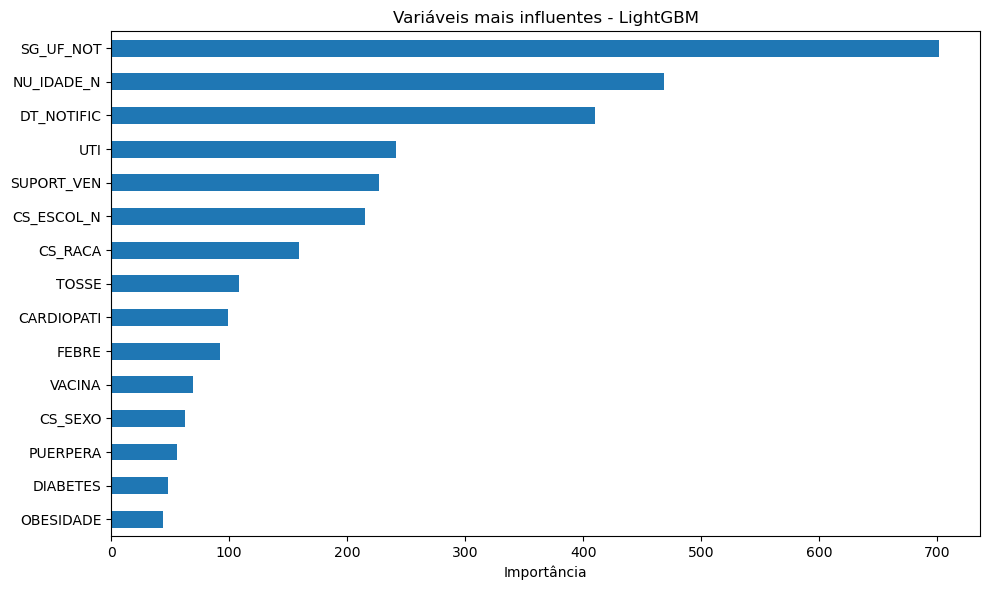

In [193]:
model = final_pipeline.named_steps['classifier'] # Recuperação do modelo treinado no item 3.3.4

ohe = final_pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']
feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols)) # Recuperação dos nomes das features após o pré-processamento

importances_df = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False) # Define a importância das variáveis no LightGBM

top_15 = importances_df.head(15) # Seleciona as 15 mais importantes

top_15.plot(kind='barh', figsize=(10, 6), title="Variáveis mais influentes - LightGBM")
plt.xlabel("Importância")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 3.3.4.2. CURVA ROC-AUC E PRECISION-RECALL

Serve para avaliar a performance de modelos de classificação, especialmente quando o problema é desbalanceado no caso da curva Precision-Recall, exatamente o que foi constatado no decorrer desta análise.

##### 3.4.4.2.1. CURVA ROC-AUC

Avalia a capacidade do modelo de separar as classes (não óbito e óbito) em todos os limiares possíveis.

O eixo x representa o falsos positivos, ou seja, a % de não óbitos classificados como óbitos. Enquanto o eixo y representa o recall, ou seja, a % de óbitos corretamente identificados.

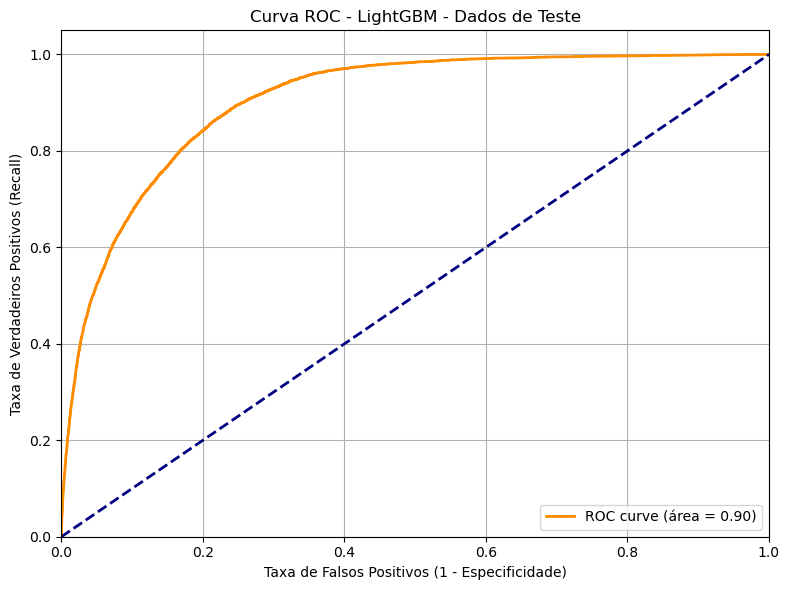

Área sob a curva (AUC) = 0.90, significa que o modelo tem 90% de chance de classificar corretamente um caso positivo vesus um caso negativo aleatório.

In [196]:
# Treina o pipeline no treino
final_pipeline.fit(X_train, y_train)

# Faz predição de probabilidade no teste
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Calcula curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plota curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC - LightGBM - Dados de Teste')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show();

display(Markdown('Área sob a curva (AUC) = 0.90, significa que o modelo tem 90% de chance de classificar corretamente um caso positivo vesus um caso negativo aleatório.'))

##### 3.4.4.2.2. PRECISION-RECALL

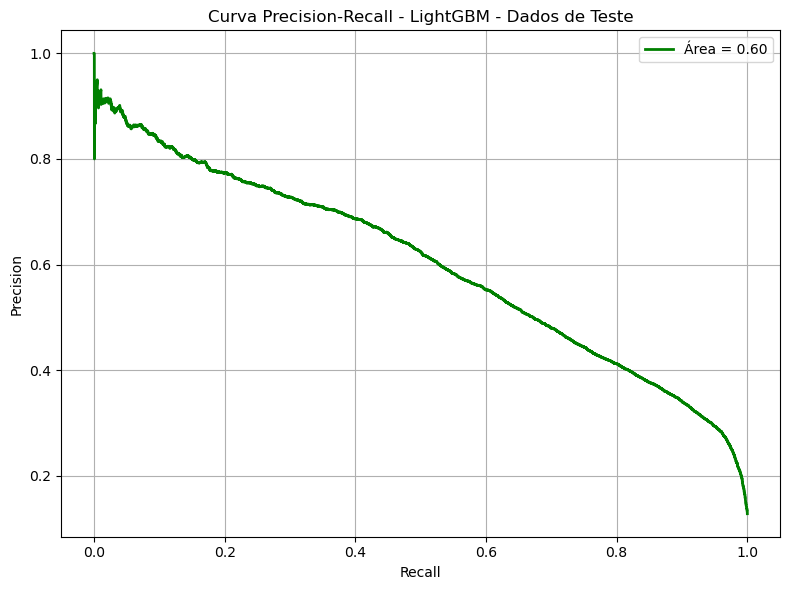

O modelo tem uma área sob a curva Precision-Recall de 0.60, o que é razoável, mas não muito alto.

A curva desce rapidamente, isso indica que, conforme o modelo tenta aumentar o recall, ou seja, detectar mais óbitos, a precisão cai consideravelmente.

Em outras palavras, é dizer que o modelo começa a errar mais ao tentar acertar tudo.

In [195]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Área = {avg_prec:.2f}')
plt.title('Curva Precision-Recall - LightGBM - Dados de Teste')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

display(Markdown('O modelo tem uma área sob a curva Precision-Recall de 0.60, o que é razoável, mas não muito alto.\n\nA curva desce rapidamente, isso indica que, conforme o modelo tenta aumentar o recall, ou seja, detectar mais óbitos, a precisão cai consideravelmente.\n\nEm outras palavras, é dizer que o modelo começa a errar mais ao tentar acertar tudo.'))

## 4. CONCLUSÃO E RECOMENDAÇÕES

### 4.1. ANÁLISE TEMPORAL

- Identificar quais são os períodos de maior incidência de SRAG (momento com queda de temperatura e com maior concentração de pessoas).
- Comparação com anos anteriores podem mostrar um padrão nos indicadores, mas como os dados serão altamente impactados pela pandemia de COVID-19, é interesse que esse monitoramente utilize como referência o ano de 2023 em diante.

### 4.2. MEDIDAS PÚBLICAS

- A vacinação da população mostrou ser uma excelente alternativa para a prevenção do agravamento dos casos de SRAG e, consequentemete, a redução no número de óbitos na parcela vacinada da população.
- Fortalecer a rede de atenção primária para diagnóstico precoce, acompanhamento de grupos de risco e monitoramento de comormidades.
- Melhorar a qualidade dos registros padronizando o preenchimento, reduzindo os campos com 'Ignorado' (ou nulo) e integrar os sistemas de informação.
- Ampliar a rede de atendimento em regiões críticas.
- Investir em equipamentos e treinamento de profissionais, além de utilizar o avanço da inteligência artificial como apoio na classificação dos pacientes.
- Desenvolver sistemas de alerta precoce para períodos de maior indicência de SRAG, regiões com aumento de casos e grupos de risco específicos.

### 4.3. PERFIL DEMOGRÁFICO

- As faixas etárias mais vulneráveis se mostraram mais suscetíveis ao agravamento de problemas de saúde causados pela SRAG. A priorização dessa população nas campanhas de vacinação, conforme adotado pelo governo, demonstrou-se adequada com base na análise dos dados por idade.
- Fatores de risco como obesidade, cardiopatias e diabetes devem ser observados com atenção por toda a população, uma vez que os dados corroboram a ideia de que pessoas com comorbidades apresentam maior risco de complicações decorrentes da SRAG.

#### 4.3.1. DISTRIBUIÇÃO GEOGRÁFICA

- A variável geográfica mostrou forte influência sobre o número de registros de SRAG, o que pode estar diretamente relacionado a regiões com maior densidade demográfica e melhor acesso aos serviços de saúde, reduzindo a subnotificação.

### 4.4. PERFORMANCE DOS MODELOS

- Os modelos foram treinados de forma correta e apresentaram resultados medianos a satisfatórios. A alta acurácia em todos os modelos pode ser justificada pelo desbalanceamento das classes, dessa forma, mesmo que o modelo chute, caso seja a classe majoritária, terá uma alta acurácia.
- A curva Precision-Recall mostrou que os resultados encontrados ainda não são os ideais. Por ser tratar de um problema de saúde pública, é importante que os modelos prevejam com assertividade possíveis casos de óbito
- Devido a sensibilidade do problema, o LightGBM foi escolhido, pois apresentou o maior recall dentre os modelos treinados, apesar de uma precisão menor. Para detectar mais óbitos (recall maior), foi preciso aceitar mais falsos positivos (precisão menor).

### 4.5. DESENVOLVIMENTO DA ANÁLISE

- Foi encerrado o primeiro ciclo do CRISP-DM, mas novos ciclos devem ocorrer buscando a melhora dos resultados obtidos.
- A tunagem dos modelos pode apresentar resultados satisfatórios.
- Um melhor desempenho pode ser esperado com a utilização de um computador mais robusto, permitindo realizar o treinamento dos modelos em um cenário ideal, selecionar as features mais pertinentes por meio do Boruta, além da utilização de algoritmos como CatBoost ou Redes Neurais.
- Técnicas como SMOTE, ADASYN ou undersampling podem ser aplicadas para lidar com o desbalanceamento da variável alvo e melhorar a sensibilidade de modelos mais robustos, apresentando resultados mais satisfatórios do que apenas os parâmetro 'class_weight' e 'scale_pos_weight'.